# Protocol to extract Bounding Boxes from Fore Fetlock Projection {#sec-extract-bounding-boxes}

Data annotation was conducted using [Label Studio](https://labelstud.io/) because it is open source.
[Dr. Ambika Prasad Mishra](https://orcid.org/0000-0002-0942-0787) created the bounding boxes.

## Libraries

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils

In [2]:
import glob
import inspect
import json
import os.path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
import utils
from PIL import Image, ImageDraw

## Import Data

Radiographs are stored as TIFF files.
Because TIFF is **not** a format supported by web browsers,
we need to convert the TIFF files into PNG files.

In [3]:
radiograph_tiff_path = "/media/raniere/CityU/hkjc/pre-sale-radiographs-v1.1.0/"
radiograph_png_path = "/media/raniere/CityU/hkjc/pre-sale-radiographs-v1.1.0+png/"

In [4]:
print(inspect.getsource(utils.tiff2png))

def tiff2png(radiograph_tiff_path, radiograph_png_path):
    for tiff_filename in glob.glob("*.tiff", root_dir=radiograph_tiff_path, recursive=True):
        im = Image.open(os.path.join(radiograph_tiff_path, tiff_filename))
        im.save(
            os.path.join(radiograph_png_path, tiff_filename.replace("tiff", "png")),
            format="PNG",
        )
        im.close()



In [ ]:
utils.tiff2png(radiograph_tiff_path, radiograph_png_path)

## Bounding Boxes

We created a project in Label Studio called "Fetlock Bounding Boxes", uploaded the radiographs to it, and configure the labeling interface using

In [5]:
with open("labeling-interface/Fetlock Bounding Boxes.xml") as _file:
    configuration_file = _file.readlines()

print("".join(configuration_file))

<View>
  <Image name="image" value="$image"/>
  <RectangleLabels name="label" toName="image">
    <Label value="Fetlock" background="blue"/>
    <Label value="Proximal Phalanx" background="green"/>
    <Label value="Lateral Sesamoid" background="red"/>
    <Label value="Medial Sesamoid" background="yellow"/>
    <Label value="Condyles-Metacarpal-III" background="magenta"/>
  </RectangleLabels>
</View>



![Screenshot of Label Studio during annotation of ""Fetlock Bounding Boxes" project.](img/label-studio-fetlock-bounding-boxes.png)

After labeling the radiographs,
we downloaded the labels in the Label Studio format.

In [6]:
with open("../data-raw/raw-fore-fetlock-bounding-boxes.json") as _file:
    fetlock_json = json.loads("".join(_file.readlines()))

The number of radiographs annotated is

In [7]:
len(fetlock_json)

2376

Example of annotation from radiograph:

In [8]:
fetlock_json[0]

{'id': 52188,
 'annotations': [{'id': 36812,
   'completed_by': 1,
   'result': [{'original_width': 1464,
     'original_height': 1776,
     'image_rotation': 0,
     'value': {'x': 37.86096256684492,
      'y': 46.119929453262785,
      'width': 38.39572192513369,
      'height': 37.47795414462081,
      'rotation': 0,
      'rectanglelabels': ['Proximal Phalanx']},
     'id': 'vhVIYOemcs',
     'from_name': 'label',
     'to_name': 'image',
     'type': 'rectanglelabels',
     'origin': 'manual'},
    {'original_width': 1464,
     'original_height': 1776,
     'image_rotation': 0,
     'value': {'x': 36.57754010695187,
      'y': 17.019400352733687,
      'width': 45.66844919786095,
      'height': 19.753086419753085,
      'rotation': 0,
      'rectanglelabels': ['Fetlock']},
     'id': 'G9DWmZrZ9a',
     'from_name': 'label',
     'to_name': 'image',
     'type': 'rectanglelabels',
     'origin': 'manual'}],
   'was_cancelled': False,
   'ground_truth': False,
   'created_at': '202

We need to change the location of the image from `localhost`.

In [9]:
for image in fetlock_json:
    image["data"]["image"] = image["data"]["image"].replace(
        "http://localhost:8081/", radiograph_png_path
    )

The information need to be saved as JSON for future use.

In [10]:
with open("../data-raw/fore-fetlock-bounding-boxes.json", "w") as _file:
    _file.writelines(json.dumps(fetlock_json, indent=2))

We use https://github.com/heartexlabs/label-studio-converter to convert the annotations to COCO and YOLO format.

In [ ]:
!python \
label_studio_converter/cli.py \
-i /home/raniere/Documents/ai-for-supracondylar-lysis-detection/data-raw/fore-fetlock-bounding-boxes.json \
-c "/home/raniere/Documents/ai-for-supracondylar-lysis-detection/inst/labeling-interface/Fetlock Bounding Boxes.xml" \
-o /tmp/label-studio \
-f COCO \
--image-dir /tmp/label-studio-tmp \
--heartex-format

python: can't open file '/home/raniere/Documents/ai-for-supracondylar-lysis-detection/inst/../../label_studio_converter/cli.py': [Errno 2] No such file or directory


In [12]:
!mv \
/tmp/label-studio/result.json \
/home/raniere/Documents/ai-for-supracondylar-lysis-detection/data-raw/fore-fetlock-bounding-boxes.coco.json

mv: cannot stat '/tmp/label-studio/result.json': No such file or directory


In [13]:
!python \
label_studio_converter/cli.py \
-i /home/raniere/Documents/ai-for-supracondylar-lysis-detection/data-raw/fore-fetlock-bounding-boxes.json \
-c "/home/raniere/Documents/ai-for-supracondylar-lysis-detection/inst/labeling-interface/Fetlock Bounding Boxes.xml" \
-o /tmp/label-studio \
-f YOLO \
--image-dir /tmp/label-studio-tmp \
--heartex-format

python: can't open file '/home/raniere/Documents/ai-for-supracondylar-lysis-detection/inst/label_studio_converter/cli.py': [Errno 2] No such file or directory


In [ ]:
!mv \
/tmp/label-studio \
/home/raniere/Documents/ai-for-supracondylar-lysis-detection/data-raw/fore-fetlock-bounding-boxes.yolo

## COCO

In [14]:
with open("../data-raw/fore-fetlock-bounding-boxes.coco.json") as _file:
    fetlock_coco_json = json.loads("".join(_file.readlines()))

In [15]:
fetlock_coco_json.keys()

dict_keys(['images', 'categories', 'annotations', 'info'])

In [16]:
fetlock_coco_json["categories"]

[{'id': 0, 'name': 'Condyles-Metacarpal-III'},
 {'id': 1, 'name': 'Fetlock'},
 {'id': 2, 'name': 'Lateral Sesamoid'},
 {'id': 3, 'name': 'Medial Sesamoid'},
 {'id': 4, 'name': 'Proximal Phalanx'}]

In [17]:
fetlock_coco_json["images"][0]

{'width': 1464,
 'height': 1776,
 'id': 0,
 'file_name': '/media/raniere/CityU/hkjc/pre-sale-radiographs-v1.1.0+png/l/fore-fetlock/flexed-dp/0201.png'}

### Example of Bounding Boxes

Consider the radiograph `l/fore-fetlock/lm/0002.png`.

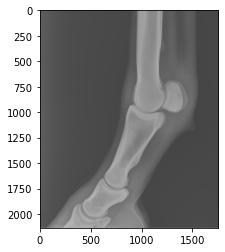

In [18]:
radiograph_filename = "l/fore-fetlock/lm/0002.png"
radiograph_full_filename = os.path.join(radiograph_png_path, radiograph_filename)

im = utils.png2rgb(radiograph_full_filename)

_ = plt.imshow(im)

Let's get the bouding boxes for this radiograph.

In [19]:
print(inspect.getsource(utils.get_bbox))

def get_bbox(filename, coco_json):
    radiograph_info = None
    radiograph_bounding_boxes = []
    
    for idx in range(len(coco_json['images'])):
        if coco_json['images'][idx]['file_name'] == filename:
            radiograph_info = coco_json['images'][idx]

    for idx in range(len(coco_json['annotations'])):
        if coco_json['annotations'][idx]['image_id'] == radiograph_info['id']:
            radiograph_bounding_boxes.append(coco_json['annotations'][idx])
    
    return radiograph_bounding_boxes



In [20]:
radiograph_bounding_boxes = utils.get_bbox(radiograph_full_filename, fetlock_coco_json)

In [21]:
radiograph_bounding_boxes

[{'id': 6916,
  'image_id': 1385,
  'category_id': 1,
  'segmentation': [],
  'bbox': [811.093846948719,
   552.8066977675898,
   673.580257806952,
   666.2656343700129],
  'ignore': 0,
  'iscrowd': 0,
  'area': 448783.3777668657},
 {'id': 6917,
  'image_id': 1385,
  'category_id': 4,
  'segmentation': [],
  'bbox': [574.342546364525,
   861.8904579658341,
   719.5740207918948,
   1013.3272699219206],
  'ignore': 0,
  'iscrowd': 0,
  'area': 729163.9779957901},
 {'id': 6918,
  'image_id': 1385,
  'category_id': 2,
  'segmentation': [],
  'bbox': [1210.0479999999998,
   680.0612691466084,
   186.88000000000002,
   336.5251641137856],
  'ignore': 0,
  'iscrowd': 0,
  'area': 62889.82266958426},
 {'id': 6919,
  'image_id': 1385,
  'category_id': 3,
  'segmentation': [],
  'bbox': [1210.0479999999998,
   677.7242888402625,
   245.28000000000003,
   327.1772428884026],
  'ignore': 0,
  'iscrowd': 0,
  'area': 80250.0341356674},
 {'id': 6920,
  'image_id': 1385,
  'category_id': 0,
  'segmen

Let's draw the bouding boxes.

In [22]:
utils.BBOX_MAP

{'Condyles-Metacarpal-III': (230, 159, 0, 100),
 'Fetlock': (86, 180, 233, 100),
 'Lateral Sesamoid': (204, 121, 167, 100),
 'Medial Sesamoid': (0, 158, 115, 100),
 'Proximal Phalanx': (213, 94, 0, 100)}

In [23]:
print(inspect.getsource(utils.coco2pil))

def coco2pil(xy):
    x, y, width, height = xy
    
    return (x, y, x + width, y + height)



In [24]:
print(inspect.getsource(utils.draw_bbox))

def draw_bbox(filename, coco_json, cmap=None, radiograph_tiff_path='', save_as=None):
    radiograph_full_filename = os.path.join(radiograph_tiff_path, filename).replace('+png', '').replace('.png', '.tiff')

    if cmap is None:
        cmap = {item['id']:BBOX_MAP[item['name']] for item in coco_json['categories']}
        
    radiograph_bounding_boxes = get_bbox(filename, coco_json)
    
    im = tiff2rgb(radiograph_full_filename)

    im_with_draw = im.copy()
    draw = ImageDraw.Draw(im_with_draw, 'RGBA')

    for bbox in radiograph_bounding_boxes:
        draw.rectangle(coco2pil(bbox['bbox']), fill=cmap[bbox['category_id']], width=0)

    if save_as is not None:
        im_with_draw.save(save_as)
    
    _ = plt.imshow(im_with_draw)



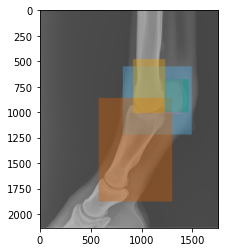

In [25]:
utils.draw_bbox(
    radiograph_full_filename,
    fetlock_coco_json,
    save_as="img/0002-with-boxes.coco.png",
)

## YOLO

In [26]:
with open("../data-raw/fore-fetlock-bounding-boxes.yolo/classes.txt") as _file:
    yolo_classes = _file.readlines()

print("".join(yolo_classes))

Condyles-Metacarpal-III
Fetlock
Lateral Sesamoid
Medial Sesamoid
Proximal Phalanx



### Example of Bounding Boxes

Consider the radiograph `l/fore-fetlock/lm/0002.png`.

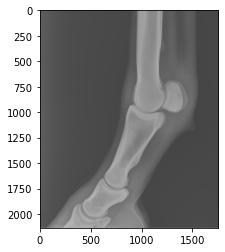

In [27]:
radiograph_filename = "l/fore-fetlock/lm/0002.png"
radiograph_full_filename = os.path.join(radiograph_png_path, radiograph_filename)

im = utils.png2rgb(radiograph_full_filename)

_ = plt.imshow(im)

Let's get the bouding boxes for this radiograph.

In [28]:
annotation_filename = os.path.join(
    "../data-raw/fore-fetlock-bounding-boxes.yolo/labels/",
    radiograph_filename.replace("/", "-").replace(".png", ".txt"),
)

In [29]:
with open(annotation_filename) as _file:
    yolo_annotation = _file.readlines()

print("".join(yolo_annotation))

1 0.6551849177238556 0.4147656905208784 0.38446361746972146 0.31192211346910714
4 0.5331789707536942 0.6407088450031808 0.41071576529217735 0.47440415258516877
2 0.7439999999999999 0.3971553610503282 0.1066666666666667 0.1575492341356674
3 0.7606666666666666 0.3938730853391684 0.14 0.15317286652078774
0 0.6093333333333331 0.34901531728665236 0.17866666666666714 0.24726477024070032



In [30]:
print(inspect.getsource(utils.draw_yolo_bbox))

def draw_yolo_bbox(filename, annotation_filename, cmap=None, radiograph_tiff_path='', save_as=None):
    radiograph_full_filename = os.path.join(radiograph_tiff_path, filename).replace('+png', '').replace('.png', '.tiff')
    
    if cmap is None:
        cmap = list(BBOX_MAP.values())

    radiograph_bounding_boxes = []
    with open(annotation_filename) as _file:
        for line in _file:
            bbox = [float(s) for s in line.split()]
            bbox[0] = int(bbox[0])
            radiograph_bounding_boxes.append(bbox)
    
    im = tiff2rgb(radiograph_full_filename)

    im_with_draw = im.copy()
    draw = ImageDraw.Draw(im_with_draw, 'RGBA')

    for bbox in radiograph_bounding_boxes:
        draw.rectangle(yolo2pillow(bbox, im), fill=cmap[bbox[0]], width=0)

    if save_as is not None:
        im_with_draw.save(save_as)
    
    _ = plt.imshow(im_with_draw)



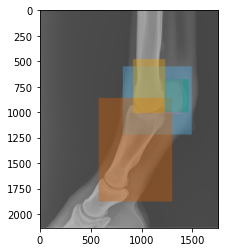

In [31]:
utils.draw_yolo_bbox(
    radiograph_full_filename,
    annotation_filename,
    save_as="img/0002-with-boxes.yolo.png",
)